### Define the model architecture using a self-attention transformer


In [1]:
import numpy as np
from PIL import Image
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import torch.nn.functional as F
from tqdm import tqdm
from torch import Tensor
import math
import matplotlib.pyplot as plt

In [2]:
# # Define model
# class ColoredPiGenerator(nn.Module):
#     def __init__(self):
#         super().__init__()
        
#         # Define diffusion model
        # self.diffusion = nn.Sequential(
        #     nn.Linear(5, 256),
        #     nn.ReLU(),
        #     nn.Linear(256, 256),
        #     nn.ReLU(),
        #     nn.Linear(256, 256),
        # )
        
#         # Define attention layer
#         self.attention = nn.MultiheadAttention(256, 2)
#         self.output_layer = nn.Linear(256, 5)
#     def forward(self, x):
#         # Diffusion model
#         x = self.diffusion(x)

#         # Attention layer
#         q = k = v = x.unsqueeze(0)
#         x, _ = self.attention(q, k, v)
        
#         x = x.squeeze(0)
#         x = self.output_layer(x)        
#         return x

# Define the model architecture using a self-attention transformer
# class ColoredPiGenerator(nn.Module):
#     def __init__(self, input_dim=5, output_dim=5, hidden_dim=256, num_layers=4, num_heads=8, dropout=0.1):
#         super(ColoredPiGenerator, self).__init__()
#         self.embedding_layer = nn.Sequential(
#             nn.Linear(input_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, hidden_dim),
#         )

#         self.transformer_encoder = nn.TransformerEncoder(
#             nn.TransformerEncoderLayer(
#                 hidden_dim, 
#                 nhead=num_heads, 
#                 dim_feedforward=hidden_dim * 4, 
#                 dropout=dropout), 
#             num_layers=num_layers)
        
#         self.output_layer = nn.Sequential(
#             nn.Linear(hidden_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, hidden_dim),
#             nn.ReLU(),
#         )
#     def forward(self, x):
#         x = self.embedding_layer(x)
#         x = self.transformer_encoder(x.unsqueeze(0))
#         x = self.output_layer(x.squeeze(0))

#         return x
    
    
# # Define the model architecture using a self-attention transformer
# class ColoredPiGenerator(nn.Module):
#     def __init__(self, input_size=5, output_size=5, hidden_size=128, num_heads=8, num_layers=3):
#         super().__init__()
#         self.embed = nn.Linear(input_size, hidden_size)
#         self.transformer = nn.TransformerEncoder(
#             nn.TransformerEncoderLayer(
#                 d_model=hidden_size, 
#                 nhead=num_heads, 
#                 dim_feedforward=hidden_size*4
#             ), 
#             num_layers=num_layers
#         )
#         self.output_layer = nn.Linear(hidden_size, output_size)

#     def forward(self, x):
#         x = self.embed(x)
#         x = self.transformer(x.unsqueeze(0))
#         x = self.output_layer(x.squeeze(0))
#         return x

# # Define the model architecture using a self-attention transformer
# class ColoredPiGenerator(nn.Module):
#     def __init__(self):
#         super(ColoredPiGenerator, self).__init__()

#         self.embedding_layer = nn.Linear(5, 256)

#         self.self_attention_layer = nn.MultiheadAttention(embed_dim=256, num_heads=8)

#         self.feedforward_layer = nn.Sequential(
#             nn.Linear(256, 512),
#             nn.ReLU(),
#             nn.Linear(512, 256)
#         )

#         self.output_layer = nn.Linear(256, 5)

#     def forward(self, x):
#         embedded_x = self.embedding_layer(x)
#         embedded_x = embedded_x.unsqueeze(0)

#         attention_output, _ = self.self_attention_layer(embedded_x, embedded_x, embedded_x)
#         feedforward_output = self.feedforward_layer(attention_output)
        
#         output = self.output_layer(feedforward_output.squeeze(0))
#         return output

# # Define the generator model using transformer-based self-attention layers
# class ColoredPiGenerator(nn.Module):
#     def __init__(self, num_points=5000, dim=5, dim_hidden=256, num_heads=4, num_layers=2, output_dim=5):
#         super(ColoredPiGenerator, self).__init__()
#         self.num_points = num_points
#         self.dim = dim
#         self.dim_hidden = dim_hidden
#         self.num_heads = num_heads
#         self.num_layers = num_layers
        
#         self.pos_emb = nn.Parameter(torch.randn(1, num_points, dim_hidden))
#         self.query_emb = nn.Parameter(torch.randn(1, num_points, dim_hidden))
#         self.value_emb = nn.Parameter(torch.randn(1, num_points, dim_hidden))
        
#         nn.init.xavier_uniform_(self.pos_emb)
#         nn.init.xavier_uniform_(self.value_emb)
#         nn.init.xavier_uniform_(self.query_emb)

#         self.embedding = nn.Sequential(
#             nn.Linear(dim, dim_hidden),
#             nn.ReLU(),
#             nn.Linear(dim_hidden, dim_hidden),
#             nn.ReLU(),
#             nn.Linear(dim_hidden, dim_hidden),
#         )
#         self.self_attns = nn.ModuleList([
#             nn.MultiheadAttention(dim_hidden, num_heads) for _ in range(num_layers)
#         ])
        
#         self.output_layer = nn.Sequential(
#             nn.Linear(dim_hidden, dim_hidden),
#             nn.ReLU(),
#             nn.Linear(dim_hidden, output_dim),
#             nn.ReLU()
#         )
    
#     def forward(self, x):
#         # Embed the input tensor
#         x = self.embedding(x)
        
#         # Add positional embeddings to the input tensor
#         x = x.unsqueeze(0) + self.pos_emb
        
#         # Apply self-attention layers
#         for self_attn in self.self_attns:
#             x, _ = self_attn(x + self.query_emb, x + self.value_emb, x)

#         # Flatten the output tensor and apply a linear layer to produce the RGB values
#         x = x.squeeze(0).view(-1, self.dim_hidden)
#         x = self.output_layer(x)
#         return x

# # Define the generator model using transformer-based self-attention layers
# class PixelTransformer(nn.Module):
#     def __init__(self, input_dim, hidden_dim, num_layers, num_heads, dropout):
#         super().__init__()
#         self.input_dim = input_dim
#         self.hidden_dim = hidden_dim
#         self.num_layers = num_layers
#         self.num_heads = num_heads
#         self.dropout = dropout
        
#         self.embedding_layer = nn.Sequential(
#             nn.Linear(input_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, hidden_dim),
#         )
#         self.pos_encoder = PositionalEncoding(hidden_dim, dropout)
#         encoder_layer = nn.TransformerEncoderLayer(hidden_dim, num_heads, hidden_dim, dropout)
#         self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
#         self.decoder = nn.Sequential(
#             nn.Linear(hidden_dim, hidden_dim),
#         )
        
#     def forward(self, x):
#         x = self.embedding_layer(x)
#         x = self.pos_encoder(x)
#         x = self.transformer_encoder(x.unsqueeze(0))
#         x = self.decoder(x.squeeze(0))
#         return x
    
# class PositionalEncoding(nn.Module):

#     def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
#         super().__init__()
#         self.dropout = nn.Dropout(p=dropout)

#         position = torch.arange(max_len).unsqueeze(1)
#         div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
#         pe = torch.zeros(max_len, 1, d_model)
#         pe[:, 0, 0::2] = torch.sin(position * div_term)
#         pe[:, 0, 1::2] = torch.cos(position * div_term)
#         self.register_buffer('pe', pe)

#     def forward(self, x: Tensor) -> Tensor:
#         """
#         Args:
#             x: Tensor, shape [seq_len, batch_size, embedding_dim]
#         """
#         x = x.unsqueeze(1) + self.pe[:x.size(0)]
#         return self.dropout(x).squeeze(1)
    
# class ColoredPiGenerator(nn.Module):
#     def __init__(self, input_dim, hidden_dim, num_layers, num_heads, dropout):
#         super().__init__()
#         self.transformer = PixelTransformer(input_dim, hidden_dim, num_layers, num_heads, dropout)
#         self.decoder = nn.Linear(hidden_dim, input_dim)
        
#     def forward(self, x):
#         x = self.transformer(x)
#         x = self.decoder(x)
#         return x

# Define the model
class SelfAttentionGenerator(nn.Module):
    def __init__(self, input_dim=5, output_dim=5, num_heads=8, hidden_dim=512, num_layers=6, batch_size=64):
        super().__init__()
        
        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.pos_embedding = nn.Parameter(torch.randn(1, batch_size, hidden_dim))
        self.layer_norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(0.5)
        self.attention_layers = nn.ModuleList([nn.MultiheadAttention(hidden_dim, num_heads) for _ in range(num_layers)])
        self.feedforward_layers = nn.ModuleList([nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 4),
            nn.GELU(),
            nn.Linear(hidden_dim * 4, hidden_dim),
            nn.Dropout(0.5)
        ) for _ in range(num_layers)])
        self.out_layer = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = self.embedding(x).unsqueeze(1)
        x = x.transpose(0, 1)  # (seq_len, batch_size, hidden_dim)
        x += self.pos_embedding
        x = self.dropout(x)
        x = self.layer_norm(x)
        for attn_layer, ff_layer in zip(self.attention_layers, self.feedforward_layers):
            x, _ = attn_layer(x, x, x)
            x = self.layer_norm(x)
            x = ff_layer(x)
            x = self.layer_norm(x)
        x = self.out_layer(x)
        return x.transpose(0, 1).squeeze(1)  # (batch_size, seq_len, output_dim) -> (batch_size, output_dim)

Epoch [150/150], Train Loss: 0.0042: 100%|██████████| 150/150 [01:03<00:00,  2.36it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


xy mean: 147.27239457069513, xy std: 59.90510891127325, xy max: 304.4693298339844, xy min: -0.5884236693382263
rgb mean: 153.70272679716095, rgb std: 39.17028266695713, rgb max: 252.2036895751953, rgb min: 22.972366333007812
Error: 15.495537037037037


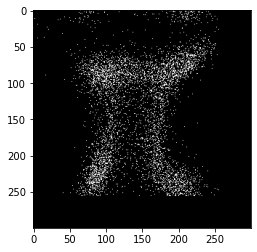

In [3]:
class ColoredPiDataset(Dataset):
    def __init__(self, image_path, xs_path, ys_path):
        self.xs = np.load(xs_path)
        self.ys = np.load(ys_path)
        self.image_array = np.array(Image.open(image_path))
        self.rgb_values = self.image_array[self.xs, self.ys]
        
        # Normalize xy values to be between 0 and 1
        self.xs, self.ys = self.xs / 299.0, self.ys / 299.0

        # Normalize rgb values to be between 0 and 1
        self.rgb_values = self.rgb_values / 255.0
        
        # # Normalize rgb values to be between -1 and 1
        # self.rgb_values = (self.rgb_values / 127.5) - 1

    def __len__(self):
        return len(self.xs)
        # return 85000

    def __getitem__(self, idx):
        if idx >= 5000:
            return torch.zeros((5)).to(torch.float32)
        return torch.tensor([self.xs[idx], self.ys[idx], self.rgb_values[idx][0], self.rgb_values[idx][1], self.rgb_values[idx][2]]).to(torch.float32)
    
# Define training function
def train(model, optimizer, criterion, dataloader, device):
    model.train()
    running_loss = 0.0
    for batch in dataloader:
        batch = batch.to(device)
        optimizer.zero_grad()
        
        noise = torch.randn(batch.shape[0], 5).to(device)
        # outputs = model(noise)
        outputs = model(batch)
        
        loss = criterion(outputs, batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * batch.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define hyperparameters
input_dim = 5 # XYRGB values
hidden_dim = 256
latent_dim = 16
num_layers = 2
num_heads = 4
dropout = 0.1

batch_size = 128
learning_rate = 3e-4
num_epochs = 150
num_samples = 500

# Load the dataset
dataset = ColoredPiDataset('sparse_pi_colored.jpg', 'pi_xs.npy', 'pi_ys.npy')
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# Initialize model, optimizer, and loss function
# model = ColoredPiGenerator().to(device)
# model = ColoredPiGenerator(num_points=batch_size).to(device)
# model = ColoredPiGenerator(input_dim, hidden_dim, num_layers, num_heads, dropout).to(device)
model = SelfAttentionGenerator(input_dim=input_dim, output_dim=input_dim, num_heads=num_heads, hidden_dim=hidden_dim, num_layers=num_layers ,batch_size=batch_size).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

# Train model
iteration = tqdm(range(num_epochs))
for epoch in iteration:
    train_loss = train(model, optimizer, criterion, dataloader, device)
    iteration.set_description('Epoch [{}/{}], Train Loss: {:.4f}'.format(epoch+1, num_epochs, train_loss))
    
# Generate some samples from the model
generated_image = np.zeros(dataset.image_array.shape)

xy  = np.zeros((len(dataloader)*batch_size, 2))
rgb = np.zeros((len(dataloader)*batch_size, 3))
for sample_idx, batch in enumerate(dataloader):
    with torch.no_grad():
        # samples = model(torch.randn(batch_size, 5).to(device))
        samples = model(batch.to(device))
        
        # Denomarlizing samples
        # samples[:, :2] = (samples[:, :2] + 1) * 149.5
        samples[:, :2] = (samples[:, :2]) * 299
        
        # Denomarlizing samples
        # samples[:, 2:] = (samples[:, 2:] + 1) * 127.5
        samples[:, 2:] = (samples[:, 2:]) * 255
        
        xy[sample_idx*batch_size:(sample_idx+1)*batch_size, :] = samples[:, :2].cpu().numpy()
        rgb[sample_idx*batch_size:(sample_idx+1)*batch_size, :] = samples[:, 2:].cpu().numpy()

        samples = samples.cpu().numpy().astype(np.uint8)
        for i in range(batch_size):
            x, y, r, g, b = samples[i]
            generated_image[x, y] = [r, g, b]
            
print(f'xy mean: {np.mean(xy)}, xy std: {np.std(xy)}, xy max: {np.max(xy)}, xy min: {np.min(xy)}')
print(f'rgb mean: {np.mean(rgb)}, rgb std: {np.std(rgb)}, rgb max: {np.max(rgb)}, rgb min: {np.min(rgb)}')
print(f'Error: {np.mean(np.abs(generated_image - dataset.image_array))}')

# Save the output image
# Image.fromarray(generated_image).save('generated_pi_colored.jpg')
plt.imshow(generated_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


xy mean: 158.74392721885576, xy std: 75.92110856525511, xy max: 360.5801696777344, xy min: -28.88292121887207
rgb mean: 140.35519873992635, rgb std: 52.69601004023269, rgb max: 277.78399658203125, rgb min: -57.80361557006836
Error: 20.196644444444445


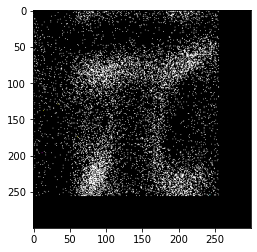

In [4]:
xy  = np.zeros((len(dataloader)*batch_size, 2))
rgb = np.zeros((len(dataloader)*batch_size, 3))
for sample_idx, batch in enumerate(dataloader):
    with torch.no_grad():
        samples = model(torch.randn(batch_size, 5).to(device))
        # samples = model(batch.to(device))
        
        # Denomarlizing samples
        # samples[:, :2] = (samples[:, :2] + 1) * 149.5
        samples[:, :2] = (samples[:, :2]) * 299
        
        # Denomarlizing samples
        # samples[:, 2:] = (samples[:, 2:] + 1) * 127.5
        samples[:, 2:] = (samples[:, 2:]) * 255
        
        xy[sample_idx*batch_size:(sample_idx+1)*batch_size, :] = samples[:, :2].cpu().numpy()
        rgb[sample_idx*batch_size:(sample_idx+1)*batch_size, :] = samples[:, 2:].cpu().numpy()

        samples = samples.cpu().numpy().astype(np.uint8)
        for i in range(batch_size):
            x, y, r, g, b = samples[i]
            generated_image[x, y] = [r, g, b]
            
print(f'xy mean: {np.mean(xy)}, xy std: {np.std(xy)}, xy max: {np.max(xy)}, xy min: {np.min(xy)}')
print(f'rgb mean: {np.mean(rgb)}, rgb std: {np.std(rgb)}, rgb max: {np.max(rgb)}, rgb min: {np.min(rgb)}')
print(f'Error: {np.mean(np.abs(generated_image - dataset.image_array))}')

# Save the output image
# Image.fromarray(generated_image).save('generated_pi_colored.jpg')
plt.imshow(generated_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


xy mean: 157.67596189749355, xy std: 58.32240154204376, xy max: 307.03515625, xy min: -25.436664581298828
rgb mean: 143.86702345980282, rgb std: 36.07859412061336, rgb max: 233.7714385986328, rgb min: 12.744540214538574
Error: 24.006451851851853


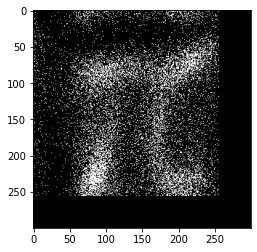

In [5]:
xy  = np.zeros((len(dataloader)*batch_size, 2))
rgb = np.zeros((len(dataloader)*batch_size, 3))
for sample_idx, batch in enumerate(dataloader):
    with torch.no_grad():
        samples = model(torch.rand(batch_size, 5).to(device))
        # samples = model(batch.to(device))
        
        # Denomarlizing samples
        # samples[:, :2] = (samples[:, :2] + 1) * 149.5
        samples[:, :2] = (samples[:, :2]) * 299
        
        # Denomarlizing samples
        # samples[:, 2:] = (samples[:, 2:] + 1) * 127.5
        samples[:, 2:] = (samples[:, 2:]) * 255
        
        xy[sample_idx*batch_size:(sample_idx+1)*batch_size, :] = samples[:, :2].cpu().numpy()
        rgb[sample_idx*batch_size:(sample_idx+1)*batch_size, :] = samples[:, 2:].cpu().numpy()

        samples = samples.cpu().numpy().astype(np.uint8)
        for i in range(batch_size):
            x, y, r, g, b = samples[i]
            generated_image[x, y] = [r, g, b]
            
print(f'xy mean: {np.mean(xy)}, xy std: {np.std(xy)}, xy max: {np.max(xy)}, xy min: {np.min(xy)}')
print(f'rgb mean: {np.mean(rgb)}, rgb std: {np.std(rgb)}, rgb max: {np.max(rgb)}, rgb min: {np.min(rgb)}')
print(f'Error: {np.mean(np.abs(generated_image - dataset.image_array))}')

# Save the output image
# Image.fromarray(generated_image).save('generated_pi_colored.jpg')
plt.imshow(generated_image)